In [1]:
!pip install kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 KB 1.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=4cebaf9bc058bcc24c9141d3ba648fa5f6cbea6ba71397a82ec3d176af998df4
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle


In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/src/olegbobrov"

In [14]:
!kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder --unzip

100%|█████████████████████████████████████▉| 1.82G/1.83G [01:03<00:00, 29.1MB/s]
100%|██████████████████████████████████████| 1.83G/1.83G [01:03<00:00, 30.8MB/s]


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1,3"

In [3]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Normalize, ToTensor, Resize, RandomHorizontalFlip
from torchvision.datasets import ImageFolder
from torch.optim import Adam, Adamax
import matplotlib.pyplot as plt
from tqdm import trange
from copy import deepcopy
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [4]:
train_transforms = Compose([
    Resize((224, 224)),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
test_transforms = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [5]:
base = "car_data/car_data/"
train_dataset = ImageFolder(base + "train", transform=train_transforms)
test_dataset = ImageFolder(base + "test", transform=test_transforms)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


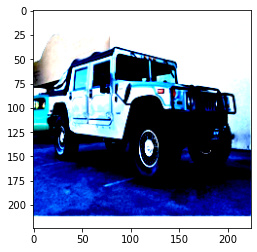

In [6]:
plt.imshow(train_dataset[0][0].cpu().numpy().transpose(1, 2, 0))

In [7]:
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=32)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=32)

In [8]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight)

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=stride+1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv3 = nn.Sequential(
                        nn.Conv2d(out_channels, 4 * out_channels, kernel_size=3, stride=1, padding=0),
                        nn.BatchNorm2d(4 * out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        self.stride = stride
        
    def forward(self, x):
        residual = x.clone()
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        if self.downsample:
            residual = self.downsample(residual)
        out += residual
        out = self.relu(out)
        return out

In [10]:
class ResNet50(nn.Module):
    def __init__(self, num_classes = 196):
        super(ResNet50, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3),
                        nn.BatchNorm2d(self.in_channels),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer0 = self._make_layer(64,  3, stride=1)
        self.layer1 = self._make_layer(128, 4, stride=2)
        self.layer2 = self._make_layer(256, 6, stride=2)
        self.layer3 = self._make_layer(512, 3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, num_classes)
        
    def _make_layer(self, mid_channels, blocks, stride=1):
        downsample = None
        output_channels = 4 * mid_channels
        if stride != 1 or self.in_channels != output_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, output_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(output_channels),
            )
        layers = []
        layers.append(ResidualBlock(self.in_channels, mid_channels, stride, downsample))
        self.in_channels = output_channels
        for i in range(blocks - 1):
            layers.append(ResidualBlock(self.in_channels, mid_channels))
        

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [11]:
model = ResNet50().cuda()
model.apply(init_weights)
model = torch.nn.parallel.DataParallel(model, device_ids=[0, 1], dim=0)

In [12]:
def predict(net, loader):
    all_labels = []
    all_preds = []
    net.eval()
    for xs, ys in loader:
        xs, ys = xs.cuda(), ys.cpu()

        with torch.no_grad():
            preds = net(xs)

        all_labels.append(ys.cpu().numpy().flatten())
        all_preds.append(preds.argmax(dim=1).cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)
    return all_labels, all_preds

def train(*, net, optimizer, loss_f, train_loader, test_loader, epochs):
    losses = []
    train_metrics = []
    test_metrics = []
    bar = trange(epochs)
    for _ in bar:
        net.train()
        for xs, ys in train_loader:
            optimizer.zero_grad()

            xs, ys = xs.cuda(), ys.cuda()
            preds = net(xs)
            loss = loss_f(preds, ys)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
        all_labels, all_preds = predict(net, test_loader)
        prec, rec, f1, _ = precision_recall_fscore_support(all_labels, all_preds, zero_division=0, average='macro')
        acc = accuracy_score(all_labels, all_preds)
        test_metrics.append((prec, rec, f1, acc))
        
        all_labels, all_preds = predict(net, train_loader)
        prec, rec, f1, _ = precision_recall_fscore_support(all_labels, all_preds, zero_division=0, average='macro')
        acc = accuracy_score(all_labels, all_preds)
        train_metrics.append((prec, rec, f1, acc))
        bar.set_description(f'Prec/Rec/F1/Acc. Train|||Test: {" | ".join(map(str, train_metrics[-1][:-1]))} ||| {" | ".join(map(str, test_metrics[-1][:-1]))}')
    return losses, train_metrics, test_metrics

In [13]:
opt_results = {}
epochs = 100
for Opt, opt_name in zip((Adam, Adamax), ('Adam', 'Adamax')):
    net = deepcopy(model)
    optimizer = Opt(net.parameters(), lr=1e-3, weight_decay=1e-3)
    loss_f = nn.CrossEntropyLoss()

    history, train_metrics_by_iter, test_metrics_by_iter = train(net=net, optimizer=optimizer, loss_f=loss_f, train_loader=train_loader, 
                                          test_loader=test_loader, epochs=epochs)
    opt_results[opt_name] = {
        'model': net,
        'losses': history,
        'train_metrics_by_iter': train_metrics_by_iter,
        'test_metrics_by_iter': test_metrics_by_iter,
    }

Prec/Rec/F1/Acc. Train|||Test: 0.6723586121725351 | 0.30460409514936726 | 0.30849689639349565 ||| 0.32985397093699137 | 0.10201652598429194 | 0.09738491423543601: 100%|██████████████████████████████████| 100/100 [1:24:24<00:00, 50.64s/it]
Prec/Rec/F1/Acc. Train|||Test: 0.9870488540546869 | 0.9858966520018329 | 0.9860810116168763 ||| 0.13184117682696284 | 0.08648030459117562 | 0.08259983349404379: 100%|████████████████████████████████████| 100/100 [1:23:12<00:00, 49.92s/it]


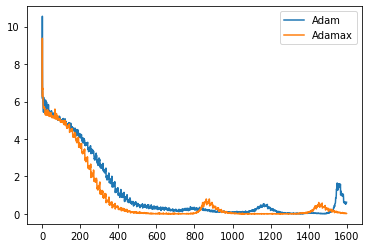

In [14]:
for opt in ['Adam', 'Adamax']:
    plt.plot(opt_results[opt]['losses'], label=opt)
plt.legend()

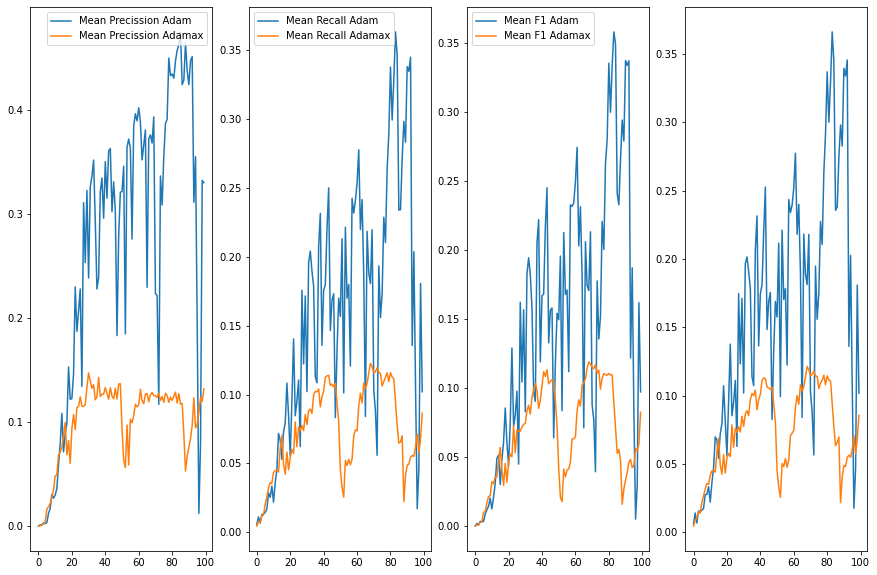

In [15]:
# Test
fig, ax = plt.subplots(1, 4, figsize=(15, 10))
for i, opt in enumerate(['Adam', 'Adamax']):
    precisions, recalls, f1_scores, acc = list(zip(*opt_results[opt]['test_metrics_by_iter']))
    ax[0].plot(np.asarray(precisions), label=f'Mean Precission {opt}')
    ax[1].plot(np.asarray(recalls), label=f'Mean Recall {opt}')
    ax[2].plot(np.asarray(f1_scores), label=f'Mean F1 {opt}')
    ax[3].plot(np.asarray(acc), label=f'Acc {opt}')

ax[0].legend(), ax[1].legend(), ax[2].legend()
plt.show()

In [ ]:
# Train
fig, ax = plt.subplots(1, 4, figsize=(15, 10))
for i, opt in enumerate(['Adam', 'Adamax']):
    precisions, recalls, f1_scores, acc = list(zip(*opt_results[opt]['train_metrics_by_iter']))
    ax[0].plot(np.asarray(precisions), label=f'Mean Precission {opt}')
    ax[1].plot(np.asarray(recalls), label=f'Mean Recall {opt}')
    ax[2].plot(np.asarray(f1_scores), label=f'Mean F1 {opt}')
    ax[3].plot(np.asarray(acc), label=f'Acc {opt}')

ax[0].legend(), ax[1].legend(), ax[2].legend()
plt.show()